In [1]:
%matplotlib inline
from yahoo_oauth import OAuth2
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
oauth = OAuth2(None, None, from_file='resources/credentials.json')

if not oauth.token_is_valid():
    oauth.refresh_access_token()

url = 'https://fantasysports.yahooapis.com/fantasy/v2/league/nhl.l.10798/standings'
response = oauth.session.get(url, params={'format':'json'})

[2018-11-15 00:49:32,122 DEBUG] [yahoo_oauth.yahoo_oauth.__init__] Checking 
[2018-11-15 00:49:32,123 DEBUG] [yahoo_oauth.yahoo_oauth.token_is_valid] ELAPSED TIME : 3966.715315103531
[2018-11-15 00:49:32,124 DEBUG] [yahoo_oauth.yahoo_oauth.token_is_valid] TOKEN HAS EXPIRED
[2018-11-15 00:49:32,124 DEBUG] [yahoo_oauth.yahoo_oauth.refresh_access_token] REFRESHING TOKEN
[2018-11-15 00:49:32,425 DEBUG] [yahoo_oauth.yahoo_oauth.token_is_valid] ELAPSED TIME : 0.30027031898498535
[2018-11-15 00:49:32,426 DEBUG] [yahoo_oauth.yahoo_oauth.token_is_valid] TOKEN IS STILL VALID


In [3]:
mappings = {'29': 'GP', 
            '1':'G',
            '2': 'A',
            '4': '+/-',
            '5': 'PIM',
            '8': 'PPP',
            '14': 'SOG',
            '31': 'HIT',
            '32': 'BLK',
            '30': 'G_GP',
            '19': 'G_W',
            '26': 'G_SV%',
            '25': 'G_SV',
            '24': 'G_SA'
           }

In [4]:
standings = {}

for k, v in response.json()['fantasy_content']['league'][1]['standings'][0]['teams'].items():
    if k == 'count':
        break
    standings[v['team'][0][2]['name']] = v['team'][1]['team_stats']['stats']

In [5]:
st = {}
labels = {}
for k, v in standings.items():
    tmp={}
    for stat in v:
        tmp[stat['stat']['stat_id']]=stat['stat']['value']
    st[k]=tmp

In [6]:
standings = pd.DataFrame.from_dict(st, orient='index')

In [7]:
standings.columns=[mappings.get(x) for x in standings.columns.map(str)]

In [8]:
standings = standings.applymap(float)

In [9]:
inv_default_scoring = ['GP', 'G_GP', 'G_SV', 'G_SA']

In [10]:
standings[[x for x in standings.columns if x not in inv_default_scoring]].apply(lambda x: pd.Series(x.rank()))

,G,A,+/-,PIM,PPP,SOG,HIT,BLK,G_W,G_SV%
Broes,8.0,4.0,4.5,1.0,9.5,7.0,7.0,5.0,12.0,12.0
Crane Hill Roosters,11.0,8.0,9.0,5.5,8.0,9.0,8.0,8.5,1.0,1.0
Flying Brings,1.0,9.0,7.0,9.0,5.0,2.0,1.0,2.0,2.5,4.0
Hip Check Rangers,5.0,6.5,1.0,3.0,7.0,8.0,5.0,8.5,9.5,2.0
Lord Kenzingtons,2.0,11.0,4.5,2.0,11.0,6.0,2.0,6.0,6.5,6.0
Ozelot's Beavers,6.0,10.0,11.0,12.0,9.5,11.0,10.0,3.0,9.5,3.0
Porsöns Hajar,3.0,1.0,2.5,10.0,2.0,10.0,9.0,11.0,2.5,7.5
SUNO MONTO SENDERS,12.0,12.0,8.0,11.0,12.0,12.0,11.0,12.0,6.5,10.0
SalmonElla,10.0,3.0,2.5,4.0,6.0,5.0,6.0,7.0,11.0,7.5
Sharp Shooters,4.0,6.5,12.0,7.5,3.5,4.0,3.0,1.0,6.5,11.0


In [11]:
adjusted_cats = ['G','A','PIM','PPP','SOG','HIT','BLK']

In [12]:
adjusted_cats_goalies = ['G_W']

In [13]:
def adjust_gp(row):
    adj_cats = row[adjusted_cats]/row['GP']
    adj_cats_g = row[adjusted_cats_goalies]/row['G_GP']
    other_cats = row[[x for x in row.index.values if x not in inv_default_scoring+adjusted_cats+adjusted_cats_goalies]]
    return adj_cats.append(other_cats).append(adj_cats_g)

In [14]:
adj_standings = standings.apply(adjust_gp, axis=1)

In [15]:
adj_standings_points = adj_standings.apply(lambda x: pd.Series(x.rank()))
adj_standings_points['TOTAL'] = adj_standings_points.sum(axis=1)

In [16]:
standings_points = standings[[x for x in standings.columns if x not in inv_default_scoring]].apply(lambda x: pd.Series(x.rank()))
standings_points['TOTAL'] = standings_points.sum(axis=1)

In [17]:
standings_points.sort_values('TOTAL', ascending=False)

,G,A,+/-,PIM,PPP,SOG,HIT,BLK,G_W,G_SV%,TOTAL
SUNO MONTO SENDERS,12.0,12.0,8.0,11.0,12.0,12.0,11.0,12.0,6.5,10.0,106.5
Ozelot's Beavers,6.0,10.0,11.0,12.0,9.5,11.0,10.0,3.0,9.5,3.0,85.0
Broes,8.0,4.0,4.5,1.0,9.5,7.0,7.0,5.0,12.0,12.0,70.0
Crane Hill Roosters,11.0,8.0,9.0,5.5,8.0,9.0,8.0,8.5,1.0,1.0,69.0
Spartak Bottenviken,9.0,2.0,6.0,7.5,3.5,1.0,12.0,10.0,4.0,9.0,64.0
SalmonElla,10.0,3.0,2.5,4.0,6.0,5.0,6.0,7.0,11.0,7.5,62.0
Sharp Shooters,4.0,6.5,12.0,7.5,3.5,4.0,3.0,1.0,6.5,11.0,59.0
Porsöns Hajar,3.0,1.0,2.5,10.0,2.0,10.0,9.0,11.0,2.5,7.5,58.5
Lord Kenzingtons,2.0,11.0,4.5,2.0,11.0,6.0,2.0,6.0,6.5,6.0,57.0
Hip Check Rangers,5.0,6.5,1.0,3.0,7.0,8.0,5.0,8.5,9.5,2.0,55.5


In [18]:
adj_standings_points.sort_values('TOTAL', ascending=False)

,G,A,PIM,PPP,SOG,HIT,BLK,+/-,G_SV%,G_W,TOTAL
SUNO MONTO SENDERS,6.0,12.0,10.0,9.0,11.0,6.0,12.0,8.0,10.0,4.0,88.0
Ozelot's Beavers,7.0,11.0,12.0,10.0,12.0,11.0,3.0,11.0,3.0,7.0,87.0
Broes,10.0,4.0,1.0,11.0,10.0,10.0,6.0,4.5,12.0,12.0,80.5
SalmonElla,12.0,3.0,5.0,7.0,5.0,8.0,9.0,2.5,7.5,10.0,69.0
Spartak Bottenviken,11.0,2.0,7.0,4.0,2.0,12.0,11.0,6.0,9.0,5.0,69.0
Sharp Shooters,5.0,9.0,8.0,5.0,4.0,3.0,1.0,12.0,11.0,9.0,67.0
Lord Kenzingtons,2.0,10.0,3.0,12.0,6.0,2.0,5.0,4.5,6.0,8.0,58.5
Crane Hill Roosters,8.0,5.0,4.0,8.0,7.0,7.0,7.0,9.0,1.0,1.0,57.0
Porsöns Hajar,3.0,1.0,11.0,1.0,9.0,9.0,10.0,2.5,7.5,3.0,57.0
The Sultans,9.0,6.0,6.0,2.0,3.0,5.0,4.0,10.0,5.0,6.0,56.0


In [19]:
def normalize_standings(col):
    return col/col.sum()

In [20]:
#norm_adj_standings = adj_standings[[x for x in adjusted_cats if x not in ['PIM']]].apply(normalize_standings).applymap(lambda x: x*78)
norm_adj_standings = adj_standings[adjusted_cats].apply(normalize_standings)
norm_adj_standings_points = norm_adj_standings.applymap(lambda x: x*78)

In [36]:
adj_standings_points

,G,A,PIM,PPP,SOG,HIT,BLK,TOTAL
Broes,10.0,4.0,1.0,11.0,10.0,10.0,6.0,52.0
Crane Hill Roosters,8.0,5.0,4.0,8.0,7.0,7.0,7.0,46.0
Flying Brings,1.0,8.0,9.0,3.0,1.0,1.0,2.0,25.0
Hip Check Rangers,4.0,7.0,2.0,6.0,8.0,4.0,8.0,39.0
Lord Kenzingtons,2.0,10.0,3.0,12.0,6.0,2.0,5.0,40.0
Ozelot's Beavers,7.0,11.0,12.0,10.0,12.0,11.0,3.0,66.0
Porsöns Hajar,3.0,1.0,11.0,1.0,9.0,9.0,10.0,44.0
SUNO MONTO SENDERS,6.0,12.0,10.0,9.0,11.0,6.0,12.0,66.0
SalmonElla,12.0,3.0,5.0,7.0,5.0,8.0,9.0,49.0
Sharp Shooters,5.0,9.0,8.0,5.0,4.0,3.0,1.0,35.0


In [22]:
adj_standings_points = adj_standings_points[adjusted_cats]

In [23]:
norm_adj_standings_points['TOTAL'] = norm_adj_standings_points.sum(axis=1)
adj_standings_points['TOTAL'] = adj_standings_points.sum(axis=1)

/home/tall/Dev/Python/fantasy-api/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


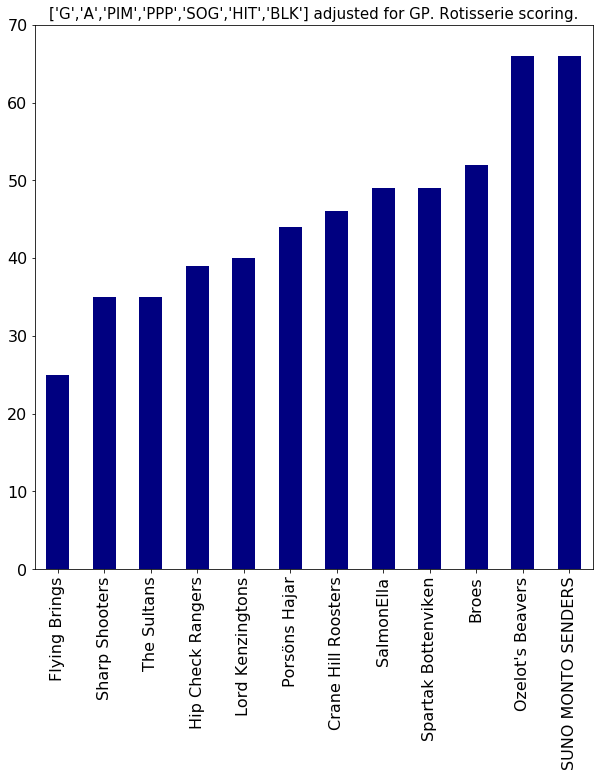

In [41]:
title = "['G','A','PIM','PPP','SOG','HIT','BLK'] adjusted for GP. Rotisserie scoring."
ax1 = adj_standings_points['TOTAL'].sort_values().plot(kind='bar',figsize=(10,12), title=title, fontsize=16, colormap='jet')
ax1.set_ylim(0, 70)
ax1.title.set_size(15)
plt.gcf().subplots_adjust(bottom=0.25)
plt.savefig('adjusted.png')


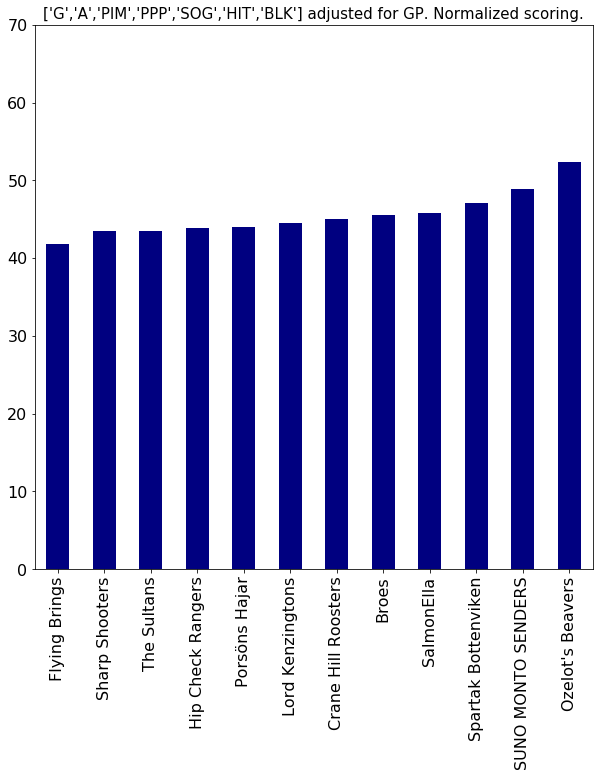

In [42]:
title = "['G','A','PIM','PPP','SOG','HIT','BLK'] adjusted for GP. Normalized scoring."
ax1 = norm_adj_standings_points['TOTAL'].sort_values().plot(kind='bar',figsize=(10,12), title=title, fontsize=16, colormap='jet')
ax1.set_ylim(0, 70)
ax1.title.set_size(15)
plt.gcf().subplots_adjust(bottom=0.25)
plt.savefig('normalized.png')

In [26]:
adj = adj_standings_points['TOTAL'].sort_values(ascending=False).to_frame()
adj.columns = ['ADJUSTED']
adj['ADJ_POSITION']=adj['ADJUSTED'].rank(ascending=False)

In [27]:
nor = norm_adj_standings_points['TOTAL'].sort_values(ascending=False).to_frame()
nor.columns = ['NORMALIZED']
nor['NOR_POSITION']=nor['NORMALIZED'].rank(ascending=False)

In [28]:
adj_nor = adj.join(nor)

In [29]:
adj_nor['CHANGE'] = adj_nor['ADJ_POSITION']-adj_nor['NOR_POSITION']

In [34]:
adj_nor.sort_values('CHANGE')

,ADJUSTED,ADJ_POSITION,NORMALIZED,NOR_POSITION,CHANGE
Broes,52.0,3.0,45.597596,5.0,-2.0
Porsöns Hajar,44.0,7.0,43.961351,8.0,-1.0
SUNO MONTO SENDERS,66.0,1.5,48.888733,2.0,-0.5
Sharp Shooters,35.0,10.5,43.474164,11.0,-0.5
Crane Hill Roosters,46.0,6.0,45.086444,6.0,0.0
Hip Check Rangers,39.0,9.0,43.859454,9.0,0.0
Flying Brings,25.0,12.0,41.783190,12.0,0.0
Ozelot's Beavers,66.0,1.5,52.404508,1.0,0.5
SalmonElla,49.0,4.5,45.824062,4.0,0.5
The Sultans,35.0,10.5,43.528441,10.0,0.5
